## Importing Libraries

In [1]:
import imageio
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import backend as K
from PIL import Image

%matplotlib inline

In [2]:
tf.config.threading.set_inter_op_parallelism_threads(8)
tf.config.threading.set_intra_op_parallelism_threads(8)

## Image and Path Configurations

In [3]:
path = '../'
image_path = os.path.join(path,'data/train_images/')
mask_path = os.path.join(path,'data/train_masks/')

training_iter = "training_2"
checkpoint_path = "checkpoints/training_2/cp.ckpt"
save_weights_location = "saved_weights/"+ training_iter +"/"
save_model_location = "saved_models/"+ training_iter +"/"

INPUT_SIZE = 512
INPUT_SIZE_H = 4000
INPUT_SIZE_W = 3000
N_CLASSES = 25
N_CHANNEL = 3

## Importing images and masks

In [4]:
image_names = sorted(os.listdir(image_path))
mask_names = sorted(os.listdir(mask_path))

In [5]:
image_names = image_names[0:100]
mask_names = mask_names[0:100]

In [6]:
image_list = [image_path+i for i in image_names]
mask_list = [mask_path+i for i in mask_names]

In [7]:
print('Total number of images = {}'.format(len(image_list)))
print('Total number of masks = {}'.format(len(mask_list)))

Total number of images = 100
Total number of masks = 100


## View an image and mask

In [8]:
N = 20
print('Image to be viewed: {}'.format(image_names[N]))
print('Mask to be viewed: {}'.format(mask_names[N]))

Image to be viewed: 6444.jpg
Mask to be viewed: 6444.png


Text(0.5, 1.0, 'Segmentation')

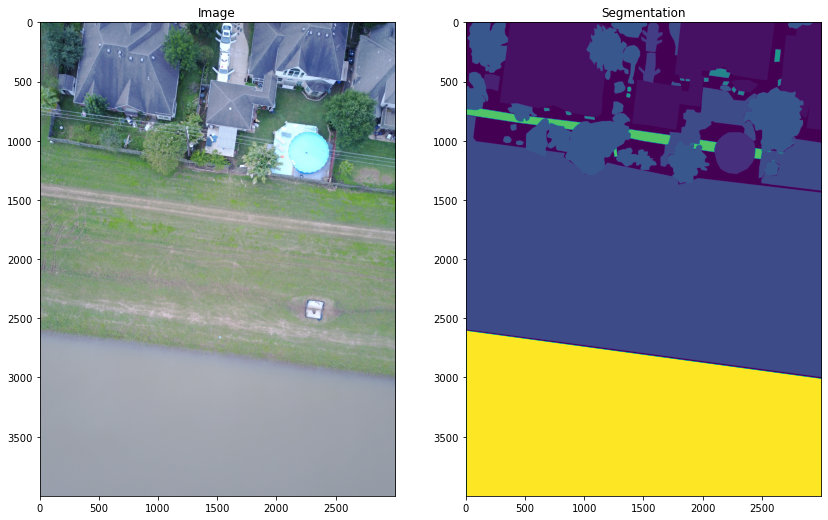

In [9]:
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

## Convert to Dataset

In [10]:
# Making tensors out of the list of strings of images and masks
image_list_tn = tf.constant(image_list)
mask_list_tn = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_list_tn, mask_list_tn))

2022-01-02 01:41:31.495748: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../data/train_images/10172.jpg', shape=(), dtype=string)
tf.Tensor(b'../data/train_masks/10172.png', shape=(), dtype=string)


In [12]:
# mask_path = '../data/train_masks/10172.png'
# mask = tf.io.read_file(mask_path)
# # print(type(mask))tf

# mask = tf.image.decode_png(mask, channels=3)
# print(type(mask))
# print(mask.shape)
# # print(mask)

# mask1 = tf.math.reduce_max(mask, axis=-1, keepdims=True)
# print(type(mask1))
# print(mask1.shape)

# input_mask = tf.image.resize(mask1, (512, 512), method='nearest')
# print(type(input_mask))
# print(input_mask.shape)

# cat_mask = to_categorical(input_mask,25)
# print(type(cat_mask))
# print(cat_mask.shape)

# cat_tf_mask = tf.one_hot(input_mask,25)
# print(type(cat_tf_mask))
# print(cat_tf_mask.shape)

In [13]:
#TO BE TRIED:
#     # Normalize the values
#     X = X.astype('float32')
#     X = (X / X.max() - 0.5) * 2   # put X in range [-1, 1]
#     Y = Y.astype('float32') / 255 # put Y in range [0, 1]
    
#     test_size = test_size/float(training_size+test_size)
    
#     X_train, X_val, Y_train, Y_val = train_test_split(
#         X, Y, test_size=test_size, random_state=42)
    
#     return X_train, Y_train, X_val, Y_val

In [14]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=N_CHANNEL)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=N_CHANNEL)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)    
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (512, 512), method='nearest')
    input_image = input_image / 255.

    input_mask = tf.image.resize(mask, (512, 512), method='nearest')
#     input_mask = tf.one_hot(input_mask,25)    
#     input_mask = to_categorical(input_mask,25)

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

for i, m in image_ds.take(1):
    print("Size of IMAGE pre-processing: {}".format(i.shape))
    print("Size of MASK pre-processing: {}".format(m.shape))
print("+++++++++++++++++++++++++++++++++++++++++++++")
for i, m in processed_image_ds.take(1):
    print("Size of IMAGE post-processing: {}".format(i.shape))
    print("Size of MASK post-processing: {}".format(m.shape))

Size of IMAGE pre-processing: (4000, 3000, 3)
Size of MASK pre-processing: (4000, 3000, 1)
+++++++++++++++++++++++++++++++++++++++++++++
Size of IMAGE post-processing: (512, 512, 3)
Size of MASK post-processing: (512, 512, 1)


In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(4000, 3000, 1)


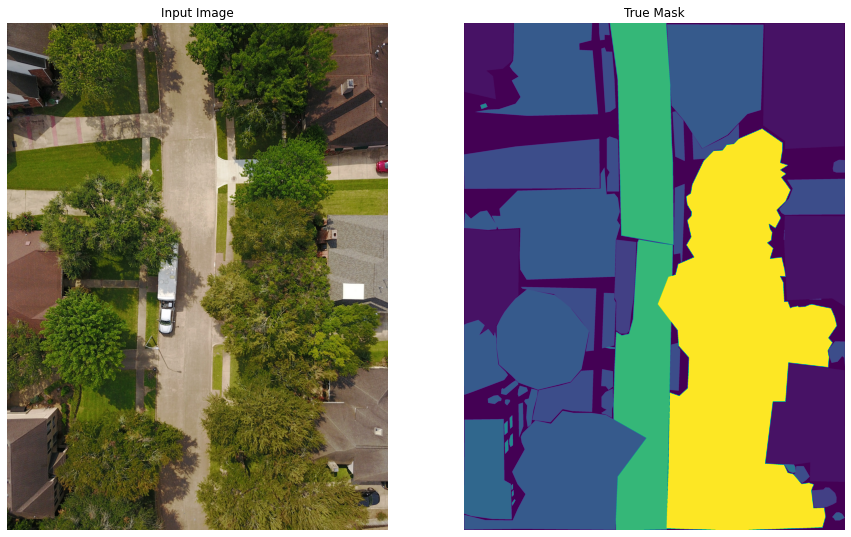

In [16]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(512, 512, 1)


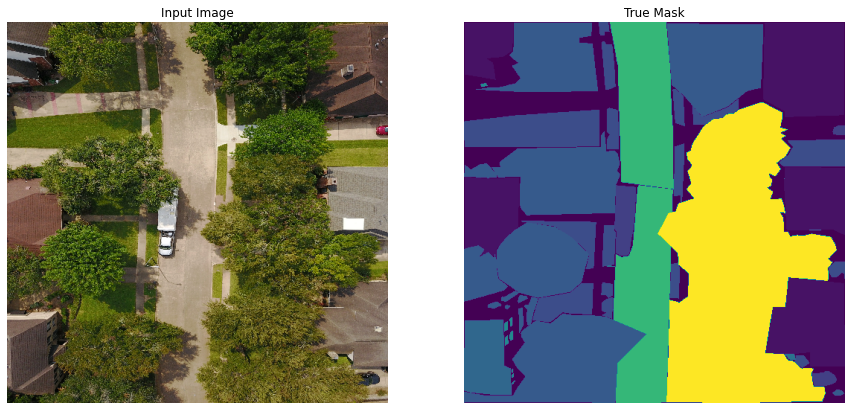

In [17]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

## Building the UNet model

In [18]:
def get_unet(lr=0.01):
#     inputs = Input((INPUT_SIZE_H, INPUT_SIZE_W, N_CHANNEL))
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = (pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = (pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = (pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = (pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1))(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
    
#     unet.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    # model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[dice_coef])

    return model

# https://kegui.medium.com/how-to-calculate-the-output-size-when-using-conv2dtranspose-layer-19124c79aa15

In [19]:
unet = get_unet()

In [20]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [21]:
# # Define metrics
# smooth = 1.

# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [22]:
# In semantic segmentation, you need as many masks as you have object classes. 
# In our dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a 
# certain class - 0 to 24. The correct class is the layer with the higher probability. 

# Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with 
# lots of classes and to perform pixel-wise multiclass prediction. 

# unet.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [23]:
print(type(image_ds))
print(type(processed_image_ds))

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>


## Creating necessary callbacks

In [24]:

# Define callback to save model checkpoints
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
model_checkpoint = ModelCheckpoint(os.path.join('checkpoints', training_iter, 'weights.{epoch:02d}.hdf5'), 
                                   monitor='loss', save_best_only=True) #-{val_loss:.5f}

# Define callback to reduce learning rate when learning stagnates
# This won't actually kick in with only 5 training epochs, but I'm assuming you'll train for hundreds of epochs when you get serious about training this NN.
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, epsilon=0.002, cooldown=2)

# TensorBoard visuluaziations... this stuff is so freaking cool
# %load_ext tensorboard
# %tensorboard --logdir /tmp/tboard_logs8
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs8', histogram_freq=0, write_graph=True, write_images=True)



# # Include the epoch in the file name (uses `str.format`)
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [25]:
class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('Evaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('Evaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

## Training the model

In [26]:
EPOCHS = 20
# VAL_SUBSPLITS = 5
BUFFER_SIZE = 150
BATCH_SIZE = 10

In [27]:
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

(TensorSpec(shape=(512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(512, 512, 1), dtype=tf.uint8, name=None))


In [28]:
model_history = unet.fit(train_dataset, epochs=EPOCHS, callbacks=[MyCustomCallback(),tensorboard])

Epoch 1/20
Training: batch 0 begins at 01:41:43.503615


2022-01-02 01:41:55.251887: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 46 of 150
2022-01-02 01:42:05.364037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 93 of 150
2022-01-02 01:42:06.858014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


Training: batch 0 ends at 01:43:06.838570
      1/Unknown - 83s 83s/step - loss: 3.2191 - accuracy: 0.0556Training: batch 1 begins at 01:43:06.840571


2022-01-02 01:43:06.839064: I tensorflow/core/profiler/lib/profiler_session.cc:184] Profiler session started.


Training: batch 1 ends at 01:44:05.383524
      2/Unknown - 142s 71s/step - loss: 3.1534 - accuracy: 0.0928Training: batch 2 begins at 01:44:05.402562
Training: batch 2 ends at 01:45:03.767040
      3/Unknown - 200s 67s/step - loss: 64623330.1023 - accuracy: 0.1391Training: batch 3 begins at 01:45:03.767711
Training: batch 3 ends at 01:46:03.631015
      4/Unknown - 260s 65s/step - loss: 48467498.2658 - accuracy: 0.1379Training: batch 4 begins at 01:46:03.633674
Training: batch 4 ends at 01:47:03.102821
      5/Unknown - 320s 64s/step - loss: 38773999.2314 - accuracy: 0.1651Training: batch 5 begins at 01:47:03.104095
Training: batch 5 ends at 01:48:02.742695
      6/Unknown - 379s 63s/step - loss: 32311667.1994 - accuracy: 0.1535Training: batch 6 begins at 01:48:02.745011
Training: batch 6 ends at 01:49:02.464662
      7/Unknown - 439s 63s/step - loss: 27695715.1397 - accuracy: 0.1683Training: batch 7 begins at 01:49:02.466998
Training: batch 7 ends at 01:50:01.398630
      8/Unknown -

2022-01-02 01:52:00.103513: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 01:52:59.248938
 1/10 [==>...........................] - ETA: 8:52 - loss: 19.6938 - accuracy: 0.1243Training: batch 1 begins at 01:52:59.250196
Training: batch 1 ends at 01:53:58.918469
 2/10 [=====>........................] - ETA: 7:55 - loss: 11.3407 - accuracy: 0.1441Training: batch 2 begins at 01:53:58.920892
Training: batch 2 ends at 01:54:58.667619
 3/10 [========>.....................] - ETA: 6:56 - loss: 9.0122 - accuracy: 0.1352 Training: batch 3 begins at 01:54:58.670160
Training: batch 3 ends at 01:55:58.106537
 4/10 [===========>..................] - ETA: 5:56 - loss: 10.0151 - accuracy: 0.1431Training: batch 4 begins at 01:55:58.109175
Training: batch 4 ends at 01:56:58.385461
 5/10 [==============>...............] - ETA: 4:58 - loss: 8.6238 - accuracy: 0.1355 Training: batch 5 begins at 01:56:58.387769
Training: batch 5 ends at 01:57:57.648849
 6/10 [=================>............] - ETA: 3:58 - loss: 9.2324 - accuracy: 0.1439Training: batch 6 b

2022-01-02 02:01:56.749531: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 02:02:55.329354
 1/10 [==>...........................] - ETA: 8:47 - loss: 2.9843 - accuracy: 0.3813Training: batch 1 begins at 02:02:55.330571
Training: batch 1 ends at 02:03:53.757027
 2/10 [=====>........................] - ETA: 7:47 - loss: 2.9817 - accuracy: 0.3530Training: batch 2 begins at 02:03:53.757697
Training: batch 2 ends at 02:04:52.020820
 3/10 [========>.....................] - ETA: 6:48 - loss: 2.9696 - accuracy: 0.3748Training: batch 3 begins at 02:04:52.023482
Training: batch 3 ends at 02:05:50.226336
 4/10 [===========>..................] - ETA: 5:50 - loss: 2.9583 - accuracy: 0.3791Training: batch 4 begins at 02:05:50.227544
Training: batch 4 ends at 02:06:48.465821
 5/10 [==============>...............] - ETA: 4:51 - loss: 2.9545 - accuracy: 0.3569Training: batch 5 begins at 02:06:48.466504
Training: batch 5 ends at 02:07:46.615710
 6/10 [=================>............] - ETA: 3:53 - loss: 2.9442 - accuracy: 0.3566Training: batch 6 begins

2022-01-02 02:11:40.234682: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 02:12:38.499209
 1/10 [==>...........................] - ETA: 8:44 - loss: 2.7689 - accuracy: 0.3412Training: batch 1 begins at 02:12:38.501573
Training: batch 1 ends at 02:13:36.388178
 2/10 [=====>........................] - ETA: 7:44 - loss: 2.7556 - accuracy: 0.3807Training: batch 2 begins at 02:13:36.389429
Training: batch 2 ends at 02:14:34.662617
 3/10 [========>.....................] - ETA: 6:46 - loss: 2.7561 - accuracy: 0.3548Training: batch 3 begins at 02:14:34.663298
Training: batch 3 ends at 02:15:33.055335
 4/10 [===========>..................] - ETA: 5:49 - loss: 2.7493 - accuracy: 0.3472Training: batch 4 begins at 02:15:33.057866
Training: batch 4 ends at 02:16:31.375101
 5/10 [==============>...............] - ETA: 4:51 - loss: 2.7367 - accuracy: 0.3592Training: batch 5 begins at 02:16:31.376285
Training: batch 5 ends at 02:17:29.673851
 6/10 [=================>............] - ETA: 3:52 - loss: 2.7335 - accuracy: 0.3453Training: batch 6 begins

2022-01-02 02:21:23.010622: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 02:22:21.497417
 1/10 [==>...........................] - ETA: 8:46 - loss: 2.5357 - accuracy: 0.4484Training: batch 1 begins at 02:22:21.500090
Training: batch 1 ends at 02:23:19.901563
 2/10 [=====>........................] - ETA: 7:47 - loss: 2.5709 - accuracy: 0.3602Training: batch 2 begins at 02:23:19.902778
Training: batch 2 ends at 02:24:18.512293
 3/10 [========>.....................] - ETA: 6:49 - loss: 2.5659 - accuracy: 0.3386Training: batch 3 begins at 02:24:18.513525
Training: batch 3 ends at 02:25:17.443830
 4/10 [===========>..................] - ETA: 5:51 - loss: 2.5775 - accuracy: 0.3282Training: batch 4 begins at 02:25:17.445101
Training: batch 4 ends at 02:26:16.459568
 5/10 [==============>...............] - ETA: 4:53 - loss: 2.5767 - accuracy: 0.3187Training: batch 5 begins at 02:26:16.460827
Training: batch 5 ends at 02:27:15.797800
 6/10 [=================>............] - ETA: 3:55 - loss: 2.5568 - accuracy: 0.3383Training: batch 6 begins

2022-01-02 02:31:13.691498: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 02:32:13.293051
 1/10 [==>...........................] - ETA: 8:56 - loss: 2.4951 - accuracy: 0.2876Training: batch 1 begins at 02:32:13.295663
Training: batch 1 ends at 02:33:12.758352
 2/10 [=====>........................] - ETA: 7:56 - loss: 2.4479 - accuracy: 0.3148Training: batch 2 begins at 02:33:12.760947
Training: batch 2 ends at 02:34:12.135402
 3/10 [========>.....................] - ETA: 6:56 - loss: 2.4373 - accuracy: 0.3404Training: batch 3 begins at 02:34:12.138092
Training: batch 3 ends at 02:35:11.159951
 4/10 [===========>..................] - ETA: 5:56 - loss: 2.4653 - accuracy: 0.3121Training: batch 4 begins at 02:35:11.162484
Training: batch 4 ends at 02:36:10.844748
 5/10 [==============>...............] - ETA: 4:57 - loss: 2.4757 - accuracy: 0.3087Training: batch 5 begins at 02:36:10.847399
Training: batch 5 ends at 02:37:10.788865
 6/10 [=================>............] - ETA: 3:58 - loss: 2.4585 - accuracy: 0.3212Training: batch 6 begins

2022-01-02 02:41:10.849511: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 02:42:10.929931
 1/10 [==>...........................] - ETA: 9:00 - loss: 2.4296 - accuracy: 0.2830Training: batch 1 begins at 02:42:10.932572
Training: batch 1 ends at 02:43:10.388965
 2/10 [=====>........................] - ETA: 7:58 - loss: 2.3805 - accuracy: 0.3232Training: batch 2 begins at 02:43:10.391573
Training: batch 2 ends at 02:44:09.942605
 3/10 [========>.....................] - ETA: 6:57 - loss: 2.3660 - accuracy: 0.3112Training: batch 3 begins at 02:44:09.945100
Training: batch 3 ends at 02:45:09.190242
 4/10 [===========>..................] - ETA: 5:57 - loss: 2.3857 - accuracy: 0.2942Training: batch 4 begins at 02:45:09.191422
Training: batch 4 ends at 02:46:08.619363
 5/10 [==============>...............] - ETA: 4:57 - loss: 2.3687 - accuracy: 0.3102Training: batch 5 begins at 02:46:08.621977
Training: batch 5 ends at 02:47:08.080448
 6/10 [=================>............] - ETA: 3:58 - loss: 2.3441 - accuracy: 0.3275Training: batch 6 begins

2022-01-02 02:51:05.144604: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 02:52:04.698090
 1/10 [==>...........................] - ETA: 8:55 - loss: 2.1826 - accuracy: 0.4123Training: batch 1 begins at 02:52:04.700922
Training: batch 1 ends at 02:53:04.041292
 2/10 [=====>........................] - ETA: 7:55 - loss: 2.2396 - accuracy: 0.3582Training: batch 2 begins at 02:53:04.043853
Training: batch 2 ends at 02:54:03.383207
 3/10 [========>.....................] - ETA: 6:55 - loss: 2.3184 - accuracy: 0.3212Training: batch 3 begins at 02:54:03.385724
Training: batch 3 ends at 02:55:02.729816
 4/10 [===========>..................] - ETA: 5:56 - loss: 2.2901 - accuracy: 0.3431Training: batch 4 begins at 02:55:02.732191
Training: batch 4 ends at 02:56:01.954157
 5/10 [==============>...............] - ETA: 4:56 - loss: 2.2848 - accuracy: 0.3373Training: batch 5 begins at 02:56:01.956590
Training: batch 5 ends at 02:57:01.061741
 6/10 [=================>............] - ETA: 3:57 - loss: 2.3008 - accuracy: 0.3281Training: batch 6 begins

2022-01-02 03:00:58.576033: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 03:01:58.625465
 1/10 [==>...........................] - ETA: 9:00 - loss: 2.2151 - accuracy: 0.3421Training: batch 1 begins at 03:01:58.628166
Training: batch 1 ends at 03:02:58.564974
 2/10 [=====>........................] - ETA: 7:59 - loss: 2.2222 - accuracy: 0.3265Training: batch 2 begins at 03:02:58.567442
Training: batch 2 ends at 03:03:58.082399
 3/10 [========>.....................] - ETA: 6:58 - loss: 2.2460 - accuracy: 0.3377Training: batch 3 begins at 03:03:58.085065
Training: batch 3 ends at 03:04:57.528433
 4/10 [===========>..................] - ETA: 5:58 - loss: 2.2278 - accuracy: 0.3508Training: batch 4 begins at 03:04:57.531055
Training: batch 4 ends at 03:05:57.244405
 5/10 [==============>...............] - ETA: 4:58 - loss: 2.2227 - accuracy: 0.3583Training: batch 5 begins at 03:05:57.247028
Training: batch 5 ends at 03:06:56.804083
 6/10 [=================>............] - ETA: 3:58 - loss: 2.2276 - accuracy: 0.3505Training: batch 6 begins

2022-01-02 03:10:54.151530: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 03:11:53.862127
 1/10 [==>...........................] - ETA: 8:57 - loss: 2.2784 - accuracy: 0.3572Training: batch 1 begins at 03:11:53.864822
Training: batch 1 ends at 03:12:53.155279
 2/10 [=====>........................] - ETA: 7:55 - loss: 2.1742 - accuracy: 0.3718Training: batch 2 begins at 03:12:53.157815
Training: batch 2 ends at 03:13:52.427550
 3/10 [========>.....................] - ETA: 6:55 - loss: 2.2165 - accuracy: 0.3430Training: batch 3 begins at 03:13:52.429882
Training: batch 3 ends at 03:14:51.523034
 4/10 [===========>..................] - ETA: 5:56 - loss: 2.2072 - accuracy: 0.3388Training: batch 4 begins at 03:14:51.525697
Training: batch 4 ends at 03:15:50.891234
 5/10 [==============>...............] - ETA: 4:56 - loss: 2.2096 - accuracy: 0.3472Training: batch 5 begins at 03:15:50.893805
Training: batch 5 ends at 03:16:50.064977
 6/10 [=================>............] - ETA: 3:57 - loss: 2.2057 - accuracy: 0.3381Training: batch 6 begins

2022-01-02 03:20:48.087839: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 03:21:47.510256
 1/10 [==>...........................] - ETA: 8:54 - loss: 2.1696 - accuracy: 0.2733Training: batch 1 begins at 03:21:47.512743
Training: batch 1 ends at 03:22:46.887354
 2/10 [=====>........................] - ETA: 7:55 - loss: 2.1865 - accuracy: 0.3159Training: batch 2 begins at 03:22:46.889908
Training: batch 2 ends at 03:23:46.430461
 3/10 [========>.....................] - ETA: 6:56 - loss: 2.1584 - accuracy: 0.3215Training: batch 3 begins at 03:23:46.433036
Training: batch 3 ends at 03:24:45.585246
 4/10 [===========>..................] - ETA: 5:56 - loss: 2.1533 - accuracy: 0.3262Training: batch 4 begins at 03:24:45.587588
Training: batch 4 ends at 03:25:44.933521
 5/10 [==============>...............] - ETA: 4:56 - loss: 2.1288 - accuracy: 0.3327Training: batch 5 begins at 03:25:44.936066
Training: batch 5 ends at 03:26:44.249114
 6/10 [=================>............] - ETA: 3:57 - loss: 2.1338 - accuracy: 0.3294Training: batch 6 begins

2022-01-02 03:30:41.445889: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 03:31:40.697801
 1/10 [==>...........................] - ETA: 8:53 - loss: 2.1354 - accuracy: 0.3397Training: batch 1 begins at 03:31:40.700201
Training: batch 1 ends at 03:32:39.878761
 2/10 [=====>........................] - ETA: 7:53 - loss: 2.1478 - accuracy: 0.3210Training: batch 2 begins at 03:32:39.881337
Training: batch 2 ends at 03:33:39.168284
 3/10 [========>.....................] - ETA: 6:54 - loss: 2.1435 - accuracy: 0.3193Training: batch 3 begins at 03:33:39.170686
Training: batch 3 ends at 03:34:38.620940
 4/10 [===========>..................] - ETA: 5:55 - loss: 2.1235 - accuracy: 0.3025Training: batch 4 begins at 03:34:38.623521
Training: batch 4 ends at 03:35:37.920310
 5/10 [==============>...............] - ETA: 4:56 - loss: 2.1077 - accuracy: 0.3193Training: batch 5 begins at 03:35:37.922990
Training: batch 5 ends at 03:36:37.608198
 6/10 [=================>............] - ETA: 3:57 - loss: 2.0961 - accuracy: 0.3321Training: batch 6 begins

2022-01-02 03:40:36.544211: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 03:41:36.451290
 1/10 [==>...........................] - ETA: 8:59 - loss: 2.0119 - accuracy: 0.3744Training: batch 1 begins at 03:41:36.453896
Training: batch 1 ends at 03:42:36.199758
 2/10 [=====>........................] - ETA: 7:58 - loss: 2.1617 - accuracy: 0.3083Training: batch 2 begins at 03:42:36.202422
Training: batch 2 ends at 03:43:35.732773
 3/10 [========>.....................] - ETA: 6:58 - loss: 2.0574 - accuracy: 0.3404Training: batch 3 begins at 03:43:35.735543
Training: batch 3 ends at 03:44:35.338902
 4/10 [===========>..................] - ETA: 5:58 - loss: 2.0496 - accuracy: 0.3359Training: batch 4 begins at 03:44:35.341512
Training: batch 4 ends at 03:45:35.490464
 5/10 [==============>...............] - ETA: 4:58 - loss: 2.0241 - accuracy: 0.3408Training: batch 5 begins at 03:45:35.492965
Training: batch 5 ends at 03:46:35.702742
 6/10 [=================>............] - ETA: 3:59 - loss: 2.0192 - accuracy: 0.3422Training: batch 6 begins

2022-01-02 03:50:34.609793: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 03:51:34.499275
 1/10 [==>...........................] - ETA: 8:58 - loss: 1.9349 - accuracy: 0.2782Training: batch 1 begins at 03:51:34.502031
Training: batch 1 ends at 03:52:34.315372
 2/10 [=====>........................] - ETA: 7:58 - loss: 1.9275 - accuracy: 0.3308Training: batch 2 begins at 03:52:34.317937
Training: batch 2 ends at 03:53:34.302238
 3/10 [========>.....................] - ETA: 6:59 - loss: 1.9342 - accuracy: 0.3448Training: batch 3 begins at 03:53:34.304843
Training: batch 3 ends at 03:54:34.173466
 4/10 [===========>..................] - ETA: 5:59 - loss: 1.9699 - accuracy: 0.3538Training: batch 4 begins at 03:54:34.175963
Training: batch 4 ends at 03:55:34.411085
 5/10 [==============>...............] - ETA: 4:59 - loss: 2.0046 - accuracy: 0.3301Training: batch 5 begins at 03:55:34.413677
Training: batch 5 ends at 03:56:34.166685
 6/10 [=================>............] - ETA: 3:59 - loss: 2.0212 - accuracy: 0.3271Training: batch 6 begins

2022-01-02 04:00:33.045270: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 04:01:32.969691
 1/10 [==>...........................] - ETA: 8:59 - loss: 2.0397 - accuracy: 0.3313Training: batch 1 begins at 04:01:32.972438
Training: batch 1 ends at 04:02:32.739148
 2/10 [=====>........................] - ETA: 7:58 - loss: 2.0058 - accuracy: 0.3390Training: batch 2 begins at 04:02:32.741753
Training: batch 2 ends at 04:03:32.012305
 3/10 [========>.....................] - ETA: 6:57 - loss: 2.0078 - accuracy: 0.3175Training: batch 3 begins at 04:03:32.015150
Training: batch 3 ends at 04:04:31.395689
 4/10 [===========>..................] - ETA: 5:57 - loss: 2.0049 - accuracy: 0.3143Training: batch 4 begins at 04:04:31.398284
Training: batch 4 ends at 04:05:30.643834
 5/10 [==============>...............] - ETA: 4:57 - loss: 1.9916 - accuracy: 0.3421Training: batch 5 begins at 04:05:30.646378
Training: batch 5 ends at 04:06:30.193189
 6/10 [=================>............] - ETA: 3:58 - loss: 1.9909 - accuracy: 0.3396Training: batch 6 begins

2022-01-02 04:10:28.145340: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 04:11:27.434525
 1/10 [==>...........................] - ETA: 8:53 - loss: 2.1496 - accuracy: 0.3185Training: batch 1 begins at 04:11:27.437225
Training: batch 1 ends at 04:12:27.260652
 2/10 [=====>........................] - ETA: 7:56 - loss: 2.0498 - accuracy: 0.3225Training: batch 2 begins at 04:12:27.263152
Training: batch 2 ends at 04:13:27.214597
 3/10 [========>.....................] - ETA: 6:57 - loss: 2.0330 - accuracy: 0.3234Training: batch 3 begins at 04:13:27.217237
Training: batch 3 ends at 04:14:26.794650
 4/10 [===========>..................] - ETA: 5:57 - loss: 2.0092 - accuracy: 0.3276Training: batch 4 begins at 04:14:26.796976
Training: batch 4 ends at 04:15:26.462893
 5/10 [==============>...............] - ETA: 4:58 - loss: 2.0346 - accuracy: 0.3049Training: batch 5 begins at 04:15:26.465539
Training: batch 5 ends at 04:16:25.980934
 6/10 [=================>............] - ETA: 3:58 - loss: 2.0006 - accuracy: 0.3212Training: batch 6 begins

2022-01-02 04:20:24.381970: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 04:21:23.928371
 1/10 [==>...........................] - ETA: 8:55 - loss: 1.8998 - accuracy: 0.3903Training: batch 1 begins at 04:21:23.931016
Training: batch 1 ends at 04:22:23.654823
 2/10 [=====>........................] - ETA: 7:57 - loss: 1.9451 - accuracy: 0.3556Training: batch 2 begins at 04:22:23.657426
Training: batch 2 ends at 04:23:23.354302
 3/10 [========>.....................] - ETA: 6:57 - loss: 1.9609 - accuracy: 0.3402Training: batch 3 begins at 04:23:23.356861
Training: batch 3 ends at 04:24:23.334455
 4/10 [===========>..................] - ETA: 5:58 - loss: 1.9783 - accuracy: 0.3387Training: batch 4 begins at 04:24:23.337059
Training: batch 4 ends at 04:25:23.137679
 5/10 [==============>...............] - ETA: 4:58 - loss: 1.9993 - accuracy: 0.3304Training: batch 5 begins at 04:25:23.140359
Training: batch 5 ends at 04:26:22.947400
 6/10 [=================>............] - ETA: 3:59 - loss: 1.9943 - accuracy: 0.3453Training: batch 6 begins

2022-01-02 04:30:22.524011: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 04:31:22.376717
 1/10 [==>...........................] - ETA: 8:58 - loss: 1.8763 - accuracy: 0.3526Training: batch 1 begins at 04:31:22.379352
Training: batch 1 ends at 04:32:22.111707
 2/10 [=====>........................] - ETA: 7:58 - loss: 1.9529 - accuracy: 0.3371Training: batch 2 begins at 04:32:22.114283
Training: batch 2 ends at 04:33:21.553540
 3/10 [========>.....................] - ETA: 6:57 - loss: 1.9720 - accuracy: 0.3451Training: batch 3 begins at 04:33:21.556194
Training: batch 3 ends at 04:34:21.820132
 4/10 [===========>..................] - ETA: 5:58 - loss: 1.9663 - accuracy: 0.3429Training: batch 4 begins at 04:34:21.822408
Training: batch 4 ends at 04:35:21.665971
 5/10 [==============>...............] - ETA: 4:59 - loss: 1.9650 - accuracy: 0.3337Training: batch 5 begins at 04:35:21.668660
Training: batch 5 ends at 04:36:21.134981
 6/10 [=================>............] - ETA: 3:59 - loss: 1.9870 - accuracy: 0.3362Training: batch 6 begins

2022-01-02 04:40:19.863634: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 04:41:19.589140
 1/10 [==>...........................] - ETA: 8:57 - loss: 1.8989 - accuracy: 0.3817Training: batch 1 begins at 04:41:19.591876
Training: batch 1 ends at 04:42:19.141655
 2/10 [=====>........................] - ETA: 7:57 - loss: 1.9637 - accuracy: 0.3511Training: batch 2 begins at 04:42:19.144077
Training: batch 2 ends at 04:43:18.660171
 3/10 [========>.....................] - ETA: 6:57 - loss: 2.0190 - accuracy: 0.3332Training: batch 3 begins at 04:43:18.662706
Training: batch 3 ends at 04:44:18.396240
 4/10 [===========>..................] - ETA: 5:57 - loss: 2.0040 - accuracy: 0.3308Training: batch 4 begins at 04:44:18.398997
Training: batch 4 ends at 04:45:17.680504
 5/10 [==============>...............] - ETA: 4:57 - loss: 2.0256 - accuracy: 0.3270Training: batch 5 begins at 04:45:17.682955
Training: batch 5 ends at 04:46:17.190168
 6/10 [=================>............] - ETA: 3:58 - loss: 1.9850 - accuracy: 0.3351Training: batch 6 begins

2022-01-02 04:50:15.268528: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


Training: batch 0 ends at 04:51:14.885987
 1/10 [==>...........................] - ETA: 8:56 - loss: 2.0209 - accuracy: 0.3417Training: batch 1 begins at 04:51:14.888662
Training: batch 1 ends at 04:52:14.300683
 2/10 [=====>........................] - ETA: 7:56 - loss: 2.0038 - accuracy: 0.3170Training: batch 2 begins at 04:52:14.303300
Training: batch 2 ends at 04:53:13.765876
 3/10 [========>.....................] - ETA: 6:56 - loss: 1.9991 - accuracy: 0.3229Training: batch 3 begins at 04:53:13.768404
Training: batch 3 ends at 04:54:13.420428
 4/10 [===========>..................] - ETA: 5:57 - loss: 1.9796 - accuracy: 0.3406Training: batch 4 begins at 04:54:13.423009
Training: batch 4 ends at 04:55:12.839473
 5/10 [==============>...............] - ETA: 4:57 - loss: 1.9483 - accuracy: 0.3581Training: batch 5 begins at 04:55:12.842015
Training: batch 5 ends at 04:56:12.572646
 6/10 [=================>............] - ETA: 3:58 - loss: 1.9674 - accuracy: 0.3473Training: batch 6 begins

2022-01-02 05:00:11.265103: W tensorflow/core/common_runtime/base_collective_executor.cc:216] BaseCollectiveExecutor::StartAbort Out of range: End of sequence
	 [[{{node IteratorGetNext}}]]


In [29]:
# save the weights manually
unet.save_weights(save_weights_location)

# save the entire model as "SavedModel"
unet.save(save_model_location)
h5py_save_location = save_model_location + "my_model.h5"
unet.save(h5py_save_location)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-01-02 05:00:12.573593: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/training_2/assets


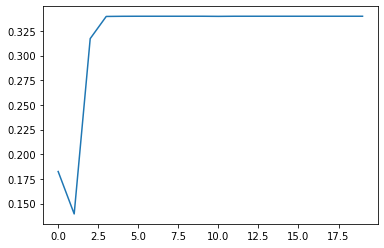

In [30]:
plt.plot(model_history.history["accuracy"])

In [31]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [32]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    for image, mask in dataset.take(num):
        pred_mask = unet.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

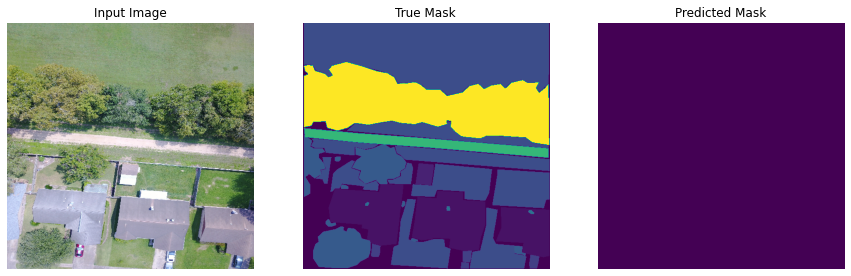

In [33]:
show_predictions(train_dataset)

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: id=64, shape=(512, 512, 3), dtype=float32, numpy=
array([[[1.07650913e-03, 9.38100799e-04, 9.53479495e-04],
        [9.53479495e-04, 7.68935075e-04, 7.68935075e-04],
        [1.27643219e-03, 1.06113043e-03, 1.04575173e-03],
        ...,
        [1.93771638e-03, 1.50711276e-03, 8.91964708e-04],
        [2.10688217e-03, 1.59938494e-03, 1.09188783e-03],
        [1.79930811e-03, 1.36870437e-03, 7.68935075e-04]],

       [[1.04575173e-03, 8.76586011e-04, 8.15071224e-04],
        [9.53479495e-04, 7.84313772e-04, 7.22798926e-04],
        [1.19953870e-03, 1.03037304e-03, 9.38100799e-04],
        ...,
        [1.50711276e-03, 1.01499434e-03, 4.15224960e-04],
        [2.46059219e-03, 1.96847389e-03, 1.33794697e-03],
        [2.44521350e-03, 1.96847389e-03, 1.29181088e-03]],

       [[1.38408307e-03, 1.16878131e-03, 1.03037304e-03],
        [1.18416001e-03, 9.84236947e-04, 8.61207314e-04],
        [1.39946176e-03, 1.16878131e-03, 1.06113043e-03],
        ...,
        [1.67627854e-03, 1.12264522e-03, 7.84313772e-04],
        [1.66089984e-03, 1.13802392e-03, 7.07420229e-04],
        [1.81468681e-03, 1.35332567e-03, 9.84236947e-04]],

       ...,

       [[1.84544420e-04, 3.07574024e-04, 1.07650914e-04],
        [2.76816631e-04, 4.61361051e-04, 9.22722102e-05],
        [1.26105349e-03, 1.47635536e-03, 9.22722102e-04],
        ...,
        [2.64513656e-03, 2.29142653e-03, 1.76855072e-03],
        [2.64513656e-03, 2.32218392e-03, 1.87620160e-03],
        [2.66051525e-03, 2.30680523e-03, 1.83006551e-03]],

       [[6.45905442e-04, 7.84313772e-04, 3.69088841e-04],
        [5.99769352e-04, 7.68935075e-04, 2.46059237e-04],
        [4.61361051e-04, 6.92041533e-04, 2.46059237e-04],
        ...,
        [2.70665134e-03, 2.35294132e-03, 1.86082290e-03],
        [2.73740874e-03, 2.38369871e-03, 1.90695899e-03],
        [2.76816613e-03, 2.39907741e-03, 1.96847389e-03]],

       [[3.69088841e-04, 4.30603657e-04, 2.15301829e-04],
        [7.68935060e-05, 1.69165709e-04, 0.00000000e+00],
        [2.92195327e-04, 4.61361051e-04, 1.99923117e-04],
        ...,
        [2.53748568e-03, 2.18377565e-03, 1.70703593e-03],
        [2.61437916e-03, 2.29142653e-03, 1.84544420e-03],
        [2.75278743e-03, 2.38369871e-03, 2.01460999e-03]]], dtype=float32)>

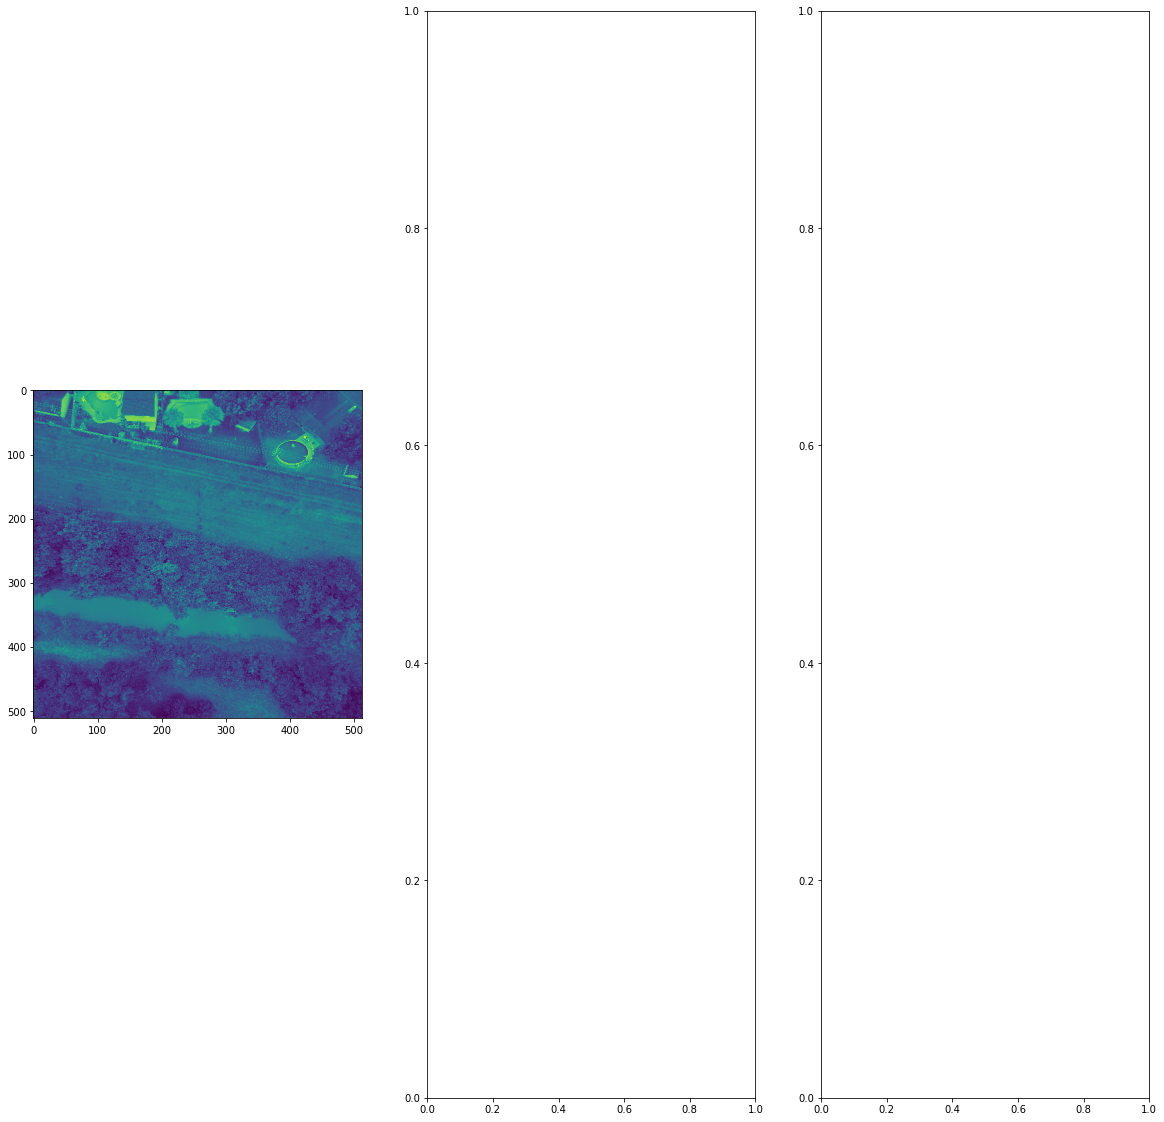

In [38]:
def prediction(dataset):
    X = 0
    y = 0
    pred = 0
    for image, mask in dataset.take(1):
#         pred_mask = unet.predict(image)
#         display([image[0], mask[0], create_mask(pred_mask)])
        X = image
        y = mask
        pred = unet.predict(image)
        
    k = np.random.randint(0, len(X))


    has_mask = True#y[k].max() > 0

    figure, j = plt.subplots(1, 3, figsize=(20, 20))
    j[0].imshow(X[k, ..., 0])
    if has_mask:
        j[0].contour(y[i].squeeze())
    k[1].imshow(y[i].squeeze())
    k[2].imshow(pred[i].squeeze())
    if has_mask:
        k[2].contour(preds[i].squeeze())
            
prediction(train_dataset)

## Kaggle Output

In [19]:


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = '../data/test_preds/'
    N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))
            mask = Image.open(dir + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()